<a href="https://colab.research.google.com/github/vladsavelyev/deeplearning/blob/master/karpathy/nanogpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
import os, requests
fname = 'tinyshakespeare.txt'
if not os.path.exists(fname):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(fname, 'w') as f:
        f.write(requests.get(data_url).text)
with open('tinyshakespeare.txt') as f:
    text = f.read()
print(len(text))

1115394


In [ ]:


import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [5]:
from typing import NamedTuple
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(1337)

class Split(NamedTuple):
    x: torch.Tensor
    y: torch.Tensor

    def get_batch(self, batch_size: int) -> 'Split':
        dataset_size = self.x.shape[0]
        block_size = self.x.shape[1]
        ix = torch.randint((dataset_size - block_size), (batch_size,), device=device)
        return Split(self.x[ix], self.y[ix])

class Dataset:
    def __init__(self, text: str, block_size: int, split_pct=0.9):
        chars = sorted(list(set(text)))
        self.vocab_size = len(chars)
        self.block_size = block_size
        self.stoi = {ch: i for i, ch in enumerate(chars)}
        self.itos = {i: ch for i, ch in enumerate(chars)}

        data = torch.tensor(self.encode(text), dtype=torch.long, device=device)
        n = int(split_pct * len(data))
        self.train = self.build_split(data[:n])
        self.test = self.build_split(data[n:])
        
    def encode(self, s: str):
        return [self.stoi[ch] for ch in s]
   
    def decode(self, ints):
        return ''.join(self.itos[i] for i in ints)

    def build_split(self, data: torch.Tensor) -> Split:
        x = torch.stack([
            data[ix:ix + self.block_size]
            for ix in range(len(data) - self.block_size)
        ])
        y = torch.stack([
            data[ix + 1:ix + 1 + self.block_size]
            for ix in range(len(data) - self.block_size)
        ])
        return Split(x, y)

dataset = Dataset(text, block_size=32)

In [6]:
torch.manual_seed(1337)

def print_batch_info(dataset, x, y):
    print('inputs:')
    print(x.shape)
    print('xb:', [dataset.decode(t.tolist()) for t in x])
    print('targets:')
    print(y.shape)
    print('yb:', [dataset.decode(t.tolist()) for t in y])
    print()
    batch_size = x.shape[0]
    block_size = x.shape[1]
    for b in range(batch_size):  # batch dimension
        for t in range(block_size):  # time dimension
            context = x[b, :t + 1]
            target = y[b, t]
            print(
                f'When input is "{dataset.decode(context.tolist())}", '
                f'the target is "{dataset.decode([target.item()])}"')

toy = Dataset('this is a test data!', block_size=3, split_pct=0.5)
xb, yb = toy.train.get_batch(batch_size=4)
print_batch_info(toy, xb, yb)


inputs:
torch.Size([4, 3])
xb: ['s i', 'his', 'thi', 'thi']
targets:
torch.Size([4, 3])
yb: [' is', 'is ', 'his', 'his']

When input is "s", the target is " "
When input is "s ", the target is "i"
When input is "s i", the target is "s"
When input is "h", the target is "i"
When input is "hi", the target is "s"
When input is "his", the target is " "
When input is "t", the target is "h"
When input is "th", the target is "i"
When input is "thi", the target is "s"
When input is "t", the target is "h"
When input is "th", the target is "i"
When input is "thi", the target is "s"


In [13]:
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.token_embedding_table = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=vocab_size
        )

    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx)  # (batch, time, channels)
    
        if targets is None:
            loss = None
        else:
            b, t, c = logits.shape
            loss = F.cross_entropy(
                logits.view(b * t, c), targets.view(b * t)
            )

        return logits, loss
    
    def generate(self, idx, max_new_tokens: int):
        # idx is (b, t) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions:
            logits, _ = self(idx)
            # focus only on the last time step:
            logits = logits[:, -1, :]  # becomes (b, c)
            probs = logits.softmax(-1)
            # sample from the distribution:
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (b, t+1)
        return idx
    
    
class Head(nn.Module):
    """ one head of self-attention """
    def __init__(self, head_size: int, embedding_dim: int, block_size: int):
        super().__init__()
        self.key = nn.Linear(embedding_dim, head_size, bias=False)
        self.query = nn.Linear(embedding_dim, head_size, bias=False)
        self.value = nn.Linear(embedding_dim, head_size, bias=False)
        self.register_buffer('tril', torch.ones((block_size, block_size)).tril())

    def forward(self, x):  # x.shape=(B, T, C=vocab_size)
        B, T, C = x.shape
        k = self.key(x)     # B, T, C -> B, T, H
        q = self.query(x)   # B, T, C -> B, T, H
        # compute attention scores ("affinities")
        w = k @ q.transpose(-2, -1) * C**-0.5  # (B, T, H) @ (B, H, T) -> B, T, T

        # w = w.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        # w = w.softmax(-1)  # B, T, T

        v = self.value(x)  # B, T, H
        out = w @ v  # (B, T, T) @ (B, T, H) -> (B, T, H)
        return out


class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size, embedding_dim, block_size):
        super().__init__()
        self.heads = nn.ModuleList([
            Head(head_size, embedding_dim, block_size)
            for _ in range(num_heads)
        ])
        self.projection = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.projection(out)
        return out
    

class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """
    def __init__(self, embedding_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim * 4), 
            nn.ReLU(),
            nn.Linear(embedding_dim * 4, embedding_dim, bias=False),  # projection layer
        )

    def forward(self, x):
        return self.net(x)
    
    
class Block(nn.Module):
    """ transformer block: communication followed by computation """
    def __init__(self, num_heads: int, embedding_dim: int, block_size: int):
        super().__init__()
        head_size = embedding_dim // num_heads
        # Communication part (share info with other tokens):
        self.sa = MultiHeadAttention(
            num_heads=num_heads, 
            head_size=head_size,
            embedding_dim=embedding_dim,
            block_size=block_size,
        )
        # Computation part (fully-connected nn on self):
        self.ffwd = FeedForward(embedding_dim)
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.ln2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class AttentionModel(nn.Module):
    def __init__(self, vocab_size: int, block_size: int, embedding_dim: int):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)
        self.pos_embedding_table = nn.Embedding(vocab_size, embedding_dim)
        self.blocks = nn.Sequential(
            Block(num_heads=4, embedding_dim=embedding_dim, block_size=block_size),
            Block(num_heads=4, embedding_dim=embedding_dim, block_size=block_size),
            Block(num_heads=4, embedding_dim=embedding_dim, block_size=block_size),
            nn.LayerNorm(embedding_dim),
        )
        self.lm_head = nn.Linear(embedding_dim, vocab_size)
        self.block_size = block_size

    def forward(self, idx, targets=None):  # (B, T)
        tok_emb = self.token_embedding_table(idx)  # (B, T, C)
        pos_emb = self.pos_embedding_table(
            torch.arange(self.block_size, device=device)
        )  # (T, C)
        x = tok_emb + pos_emb  # (B, T, C)
        x = self.blocks(x)  # (B, T, H=C)
        logits = self.lm_head(x)  # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:
            b, t, c = logits.shape
            loss = F.cross_entropy(
                logits.view(b * t, c), targets.view(b * t)
            )

        return logits, loss
    
    def generate(self, idx, max_new_tokens: int):
        # idx is (b, t) array of indices in the current context
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            # get the predictions:
            logits, _ = self(idx_cond)
            # focus only on the last time step:
            logits = logits[:, -1, :]  # becomes (b, c)
            probs = logits.softmax(-1)
            # sample from the distribution:
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (b, t+1)
        return idx


print('Initialising model...')
m = AttentionModel(
    dataset.vocab_size, 
    block_size=dataset.block_size, 
    embedding_dim=8,
)
m.to(device)
print(f'Model with {sum(p.nelement() for p in m.parameters())} params: {m}')

Initialising model...
Model with 4161 params: AttentionModel(
  (token_embedding_table): Embedding(65, 8)
  (pos_embedding_table): Embedding(65, 8)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0): Head(
            (key): Linear(in_features=8, out_features=2, bias=False)
            (query): Linear(in_features=8, out_features=2, bias=False)
            (value): Linear(in_features=8, out_features=2, bias=False)
          )
          (1): Head(
            (key): Linear(in_features=8, out_features=2, bias=False)
            (query): Linear(in_features=8, out_features=2, bias=False)
            (value): Linear(in_features=8, out_features=2, bias=False)
          )
          (2): Head(
            (key): Linear(in_features=8, out_features=2, bias=False)
            (query): Linear(in_features=8, out_features=2, bias=False)
            (value): Linear(in_features=8, out_features=2, bias=False)
          )
          (3): Head

In [14]:
@torch.no_grad()
def estimate_loss(m: nn.Module, split: Split, batch_size: int, eval_iters: int = 200) -> int:
    m.eval()
    out = torch.tensor([
        m(*split.get_batch(batch_size))[1]
        for _ in range(eval_iters)
    ], device=device).mean()
    m.train()
    return out

batch_size = 32
n_steps = 1001
lr = 1e-3

losses = []
last_outs = []
last_grads = []
linear_w_update_rates_by_parameter = {}
DEBUG = False

print('Optimising model...')
optimiser = torch.optim.AdamW(m.parameters(), lr=lr)
for step_i in range(n_steps):
    if step_i == 0 or step_i % (n_steps // 10) == 0:
        train_loss = estimate_loss(m, dataset.train, batch_size)
        test_loss = estimate_loss(m, dataset.test, batch_size)
        print(f'Step {step_i}: {train_loss=:.4f}, {test_loss=:4f}')

    logits, loss = m(*dataset.train.get_batch(batch_size))
    if DEBUG:
        logits.retain_grad()
        for p in [p for p in m.parameters() if len(p.shape) == 2]:
            p.retain_grad()

    losses.append(loss.item())
    optimiser.zero_grad(set_to_none=True)
    loss.backward()
    optimiser.step()
    if DEBUG:
        with torch.no_grad():
            ps = [p for p in m.parameters() if len(p.shape) == 2]
            for pi, p in enumerate(ps):
                if pi not in linear_w_update_rates_by_parameter:
                    linear_w_update_rates_by_parameter[pi] = []
                linear_w_update_rates_by_parameter[pi].append(
                    (lr * ps[0].grad.std() / ps[0].data.std()).abs().log10().item()
                )
            if step_i % (n_steps // 10) == 0 or n_steps == 1:
                last_outs.append(logits)
                last_grads.append(logits.grad)
                assert logits.grad is not None

# print('Evaluating model...')
# print(f'Final test split loss: {m(*dataset.test)[1]:4f}')

Optimising model...
Step 0: train_loss=4.3299, test_loss=4.335618
Step 100: train_loss=3.4326, test_loss=3.466338
Step 200: train_loss=3.2624, test_loss=3.299008
Step 300: train_loss=3.1437, test_loss=3.172911
Step 400: train_loss=3.0011, test_loss=3.018553
Step 500: train_loss=2.9006, test_loss=2.914062
Step 600: train_loss=2.8298, test_loss=2.842434
Step 700: train_loss=2.7721, test_loss=2.784171
Step 800: train_loss=2.7307, test_loss=2.740764
Step 900: train_loss=2.7092, test_loss=2.709004
Step 1000: train_loss=2.6693, test_loss=2.669655


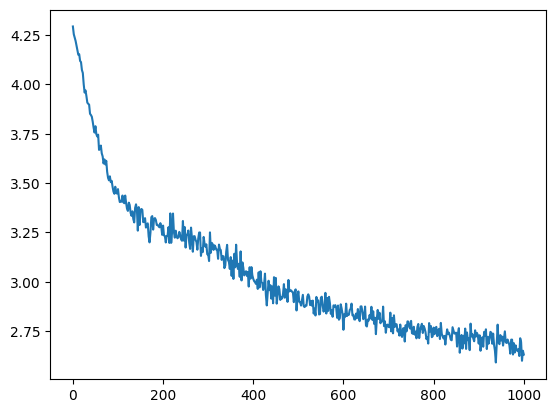

In [9]:
t = torch.tensor(losses)
window_size = n_steps // 500
if n_steps > 500:
    round_size = len(t) // window_size * window_size
    t1 = t[:round_size].view(-1, window_size).mean(1)
    t2 = t[round_size:].view(-1, 1).mean(1)
    t = torch.cat([t1, t2], dim=0)
plt.plot(torch.arange(len(t)) * window_size, t);

In [12]:
print('> Generating from model...')
idx = torch.tensor([dataset.encode(text[:32])]).to(device)
res = m.generate(idx, 200)
print(dataset.decode(res[0].tolist()))

> Generating from model...
First Citizen:
Before we proceed as os bereou stas o

QLSouve bourare -thid y ' rethe s thowt y -
ferelamoco biuritmanik,

Mssest, thens F Ios be; IM,
H:
LTMuromis an onee orl met tor my hafo, sr itd lo QOaathe!
Aerisen; f h; fey li


In [15]:
print('> Generating from model...')
idx = torch.tensor([dataset.encode(text[:32])]).to(device)
res = m.generate(idx, 200)
print(dataset.decode(res[0].tolist()))

> Generating from model...
First Citizen:
Before we proceedel m:


TARETATCRA

LRUa dome, to hor sarAIR





Txor te ,




PN' om:
CELRTIi omeno,
 ENe,, OBA

is se ISn tae' womed h mce bnre!G ith.
Z
Notfos iBThheat t laaridf fa.
AArthaslimd d tthasals s RA' n


In [ ]:
# Histogram of weights for each linear layer (not over time).
legends = []
linear_layers = [
    b.ffwd.net[0] for b in m.blocks
] + [m.lm_head]
for li, l in enumerate(linear_layers):
    w_count, w = torch.histogram(l.weight.data, density=True)
    plt.plot(w[:-1].detach(), w_count.detach())
    legends.append(f'layer {li} ({l.__class__.__name__})')
plt.legend(legends)
plt.xlim(-4, 4)
plt.ylim(0, 0.45);

In [ ]:
# Histogram of weights GRADIENTS for each linear layer (not over time).
legends = []
for li, l in enumerate(linear_layers):
    print(
        f'weight {str(tuple(l.weight.shape)):<10}: '
        f'mean: {l.weight.grad.mean().item():+.4f}, std: {l.weight.grad.std().item():.4f}, '
        f'grad:data: {(l.weight.grad / l.weight.data).mean().item():+.4f}'
    )
    w_grad_count, w_grad = torch.histogram(l.weight.grad, density=True)
    plt.plot(w_grad[:-1].detach(), w_grad_count.detach())
    legends.append(f'layer {li} ({l.__class__.__name__})')
plt.legend(legends)
plt.xlim((-0.04, 0.04));

In [ ]:
# Final linear layer outputs histogram for each step.
# Linear layers outs should stay close to unit gaussian.
legends = []
for i, t in enumerate(last_outs):
    legends.append(f'step {i * (n_steps // 10) + 1}')
    counts, xs = torch.histogram(t, density=True)
    plt.plot(xs[:-1].detach(), counts.detach())
    sat = (t.abs() > 0.97).float().mean().item()
    print(f'step {i * (n_steps // 10) + 1:<4}: '
          f'mean={t.mean().item():+.4f}  '
          f'std={t.std().item():+.4f}  '
          f'sat={sat:+.4f}')
plt.legend(legends)
plt.xlim(-4, 4)
plt.ylim(0, 0.45);

In [ ]:
# Hist of tanh outputs over time. 
# Tanh of a gaussian with long tails will have peaks close to -1 and 1, 
# meaning that such neurons won't train and will saturate i.e. any small 
# change to a large input of tanh wouldn't change the output.
# So we should not expect to see very high peaks of tanh.
legends = []
for i, t in enumerate(last_outs):
    t = t.tanh()
    legends.append(f'step {i * (n_steps // 10) + 1}')
    counts, xs = torch.histogram(t, density=True)
    plt.plot(xs[:-1].detach(), counts.detach())
    sat = (t.abs() > 0.97).float().mean().item()
    print(f'step {i * (n_steps // 10) + 1:<4}: '
          f'mean={t.mean().item():+.4f}  '
          f'std={t.std().item():+.4f}  '
          f'sat={sat:+.4f}')
plt.legend(legends)
plt.ylim((0, 2));

In [ ]:
# Histogram of tanh output gradients. Following the reasoning above, we 
# shouldn't see a lot at zero.
legends = []
for i, t in enumerate(last_grads):
    counts, xs = torch.histogram(t, density=True)
    plt.plot(xs[:-1].detach(), counts.detach())
    legends.append(f'step {i * (n_steps // 10)}')
plt.legend(legends);

In [ ]:
# Plotting update rate over step, for each layer. Ideal update rate should be 
# around 1/1000 which corresponds to the factor of -3 on the plot. Meaning, 
# that the update (learning rate std times gradient std?) is 1/1000th of data.
plt.figure(figsize=(20, 4))
legends = []
for pi, t in linear_w_update_rates_by_parameter.items():
    plt.plot(t)
    legends.append(f'Parameter {pi}')
plt.plot([0, len(linear_w_update_rates_by_parameter[1])], [-3, -3], 'k')
# plt.legend(legends);

In [ ]:
# Plotting update rate over step, for each layer. Ideal update rate should be 
# around 1/1000 which corresponds to the factor of -3 on the plot. Meaning, 
# that the update (learning rate std times gradient std?) is 1/1000th of data.
plt.figure(figsize=(20, 4))
legends = []
for pi, t in linear_w_update_rates_by_parameter.items():
    plt.plot(t)
    legends.append(f'Parameter {pi}')
plt.plot([0, len(linear_w_update_rates_by_parameter[1])], [-3, -3], 'k')
# plt.legend(legends);

In [ ]:
# Plotting update rate over step, for each layer. Ideal update rate should be 
# around 1/1000 which corresponds to the factor of -3 on the plot. Meaning, 
# that the update (learning rate std times gradient std?) is 1/1000th of data.
plt.figure(figsize=(20, 4))
legends = []
for pi, t in linear_w_update_rates_by_parameter.items():
    plt.plot(t)
    legends.append(f'Parameter {pi}')
plt.plot([0, len(linear_w_update_rates_by_parameter[1])], [-3, -3], 'k')
# plt.legend(legends);

In [ ]:
# Plotting update rate over step, for each layer. Ideal update rate should be 
# around 1/1000 which corresponds to the factor of -3 on the plot. Meaning, 
# that the update (learning rate std times gradient std?) is 1/1000th of data.
plt.figure(figsize=(20, 4))
legends = []
for pi, t in linear_w_update_rates_by_parameter.items():
    plt.plot(t)
    legends.append(f'Parameter {pi}')
plt.plot([0, len(linear_w_update_rates_by_parameter[1])], [-3, -3], 'k')
# plt.legend(legends);

In [ ]:
# Plotting update rate over step, for each layer. Ideal update rate should be 
# around 1/1000 which corresponds to the factor of -3 on the plot. Meaning, 
# that the update (learning rate std times gradient std?) is 1/1000th of data.
plt.figure(figsize=(20, 4))
legends = []
for pi, t in linear_w_update_rates_by_parameter.items():
    plt.plot(t)
    legends.append(f'Parameter {pi}')
plt.plot([0, len(linear_w_update_rates_by_parameter[1])], [-3, -3], 'k')
# plt.legend(legends);

In [ ]:
# Plotting update rate over step, for each layer. Ideal update rate should be 
# around 1/1000 which corresponds to the factor of -3 on the plot. Meaning, 
# that the update (learning rate std times gradient std?) is 1/1000th of data.
plt.figure(figsize=(20, 4))
legends = []
for pi, t in linear_w_update_rates_by_parameter.items():
    plt.plot(t)
    legends.append(f'Parameter {pi}')
plt.plot([0, len(linear_w_update_rates_by_parameter[1])], [-3, -3], 'k')
# plt.legend(legends);

In [ ]:
# Plotting update rate over step, for each layer. Ideal update rate should be 
# around 1/1000 which corresponds to the factor of -3 on the plot. Meaning, 
# that the update (learning rate std times gradient std?) is 1/1000th of data.
plt.figure(figsize=(20, 4))
legends = []
for pi, t in linear_w_update_rates_by_parameter.items():
    plt.plot(t)
    legends.append(f'Parameter {pi}')
plt.plot([0, len(linear_w_update_rates_by_parameter[1])], [-3, -3], 'k')
# plt.legend(legends);

In [ ]:
# Plotting update rate over step, for each layer. Ideal update rate should be 
# around 1/1000 which corresponds to the factor of -3 on the plot. Meaning, 
# that the update (learning rate std times gradient std?) is 1/1000th of data.
plt.figure(figsize=(20, 4))
legends = []
for pi, t in linear_w_update_rates_by_parameter.items():
    plt.plot(t)
    legends.append(f'Parameter {pi}')
plt.plot([0, len(linear_w_update_rates_by_parameter[1])], [-3, -3], 'k')
# plt.legend(legends);

In [10]:
print('> Generating from model...')
idx = torch.tensor([dataset.encode(text[:32])]).to(device)
res = m.generate(idx, 400)
print(dataset.decode(res[0].tolist()))

> Generating from model...
First Citizen:
Before we proceed our entreatenting,
I would my ragg.

GLOUCESTER:
Nay.
O, itdoties, as were us of thy's weary,
And feed the they adding, one to lies,
Geroas with old nothing not theer deep,
God-Jriach time minictions to texes advistagen:
So Glouy, I would have feather hushis grace sing of times,
Parge the purince at
the donoaring vil claur, you biriet your revery?

LEONTES:
No! my puries pace die, I do stral,
Les


In [ ]:
torch.manual_seed(1337)
B, T, C = 4, 8, 2
x = torch.randn(B, T, C)

In [ ]:
# version 1
# we want x[b, t] = mean_{i<=t} x[b, i]
xbow0 = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        xprev = x[b, :t + 1]
        xbow0[b, t] = torch.mean(xprev, 0)

In [ ]:
tril = torch.tril(torch.ones((3, 3)))
tril / tril.sum(dim=1, keepdim=True)

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

In [ ]:
# version 2
tril = torch.tril(torch.ones(T, T))
wei = tril / tril.sum(dim=1, keepdim=True)
xbow1 = wei @ x  # (B, T, T) @ (B, T, C) -> (B, T, C)
torch.allclose(xbow0, xbow1)

True

In [ ]:
# version 3
tril = torch.tril(torch.ones((T, T)))
wei = tril.masked_fill(tril == 0, float('-inf'))
wei = wei.softmax(-1)
xbow2 = wei @ x
torch.allclose(xbow0, xbow2)

True

In [ ]:
# version 4: self-attention!
torch.manual_seed(1337)
B, T, C = 4, 8, 32
x = torch.randn(B, T, C)

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)     # B, T, 16
q = query(x)   # B, T, 16
print(f'{k.shape=} {q.shape=} {k.transpose(-2, -1).shape=}')
wei = q @ k.transpose(-2, -1)  # B, T, 16 @ B, 16, T -> B, T, T

tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = wei.softmax(-1)

v = value(x)
print(f'{x.shape=} {v.shape=}')
out = wei @ v
print(f'{wei.shape=} {out.shape=}')


k.shape=torch.Size([4, 8, 16]) q.shape=torch.Size([4, 8, 16]) k.transpose(-2, -1).shape=torch.Size([4, 16, 8])
x.shape=torch.Size([4, 8, 32]) v.shape=torch.Size([4, 8, 16])
wei.shape=torch.Size([4, 8, 8]) out.shape=torch.Size([4, 8, 16])
